# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [2]:
from task import gini, entropy, gain

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [3]:
from task import DecisionTreeLeaf, DecisionTreeNode

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [4]:
from task import DecisionTreeClassifier

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [5]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [6]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

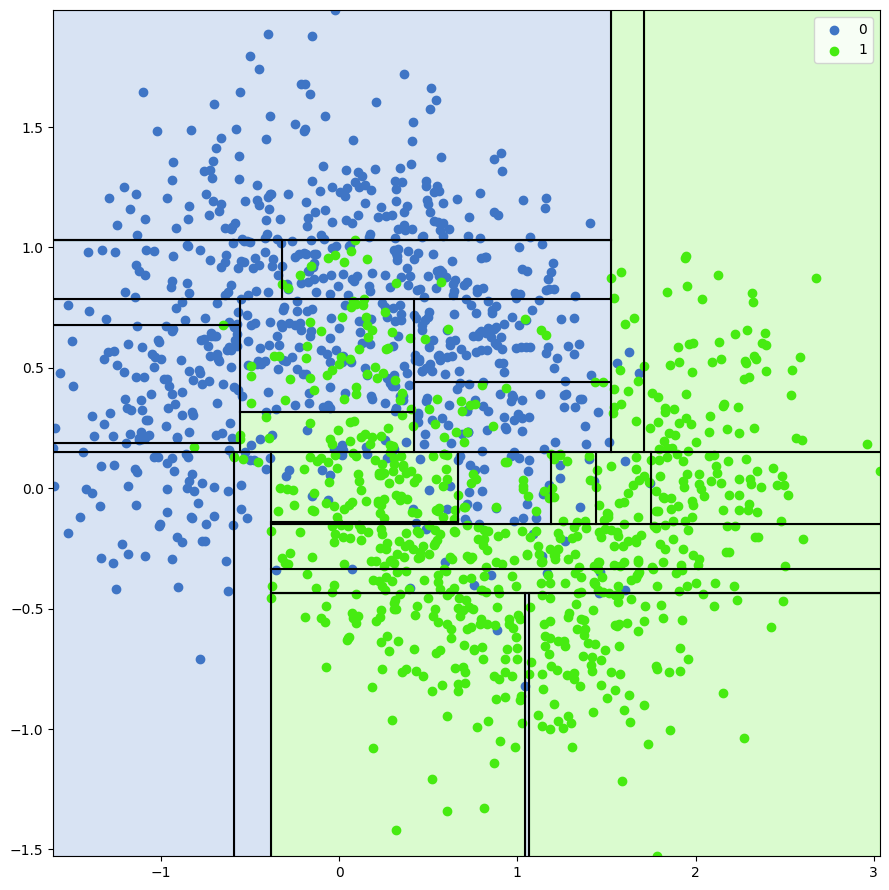

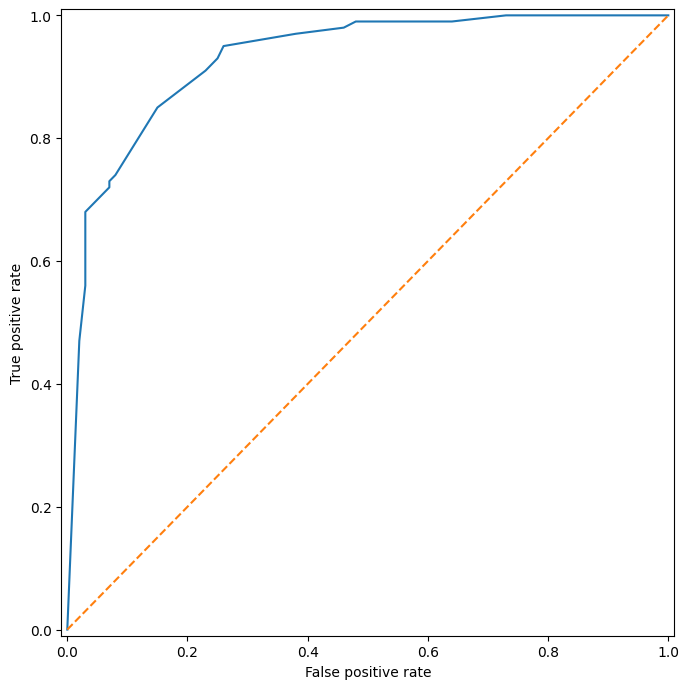

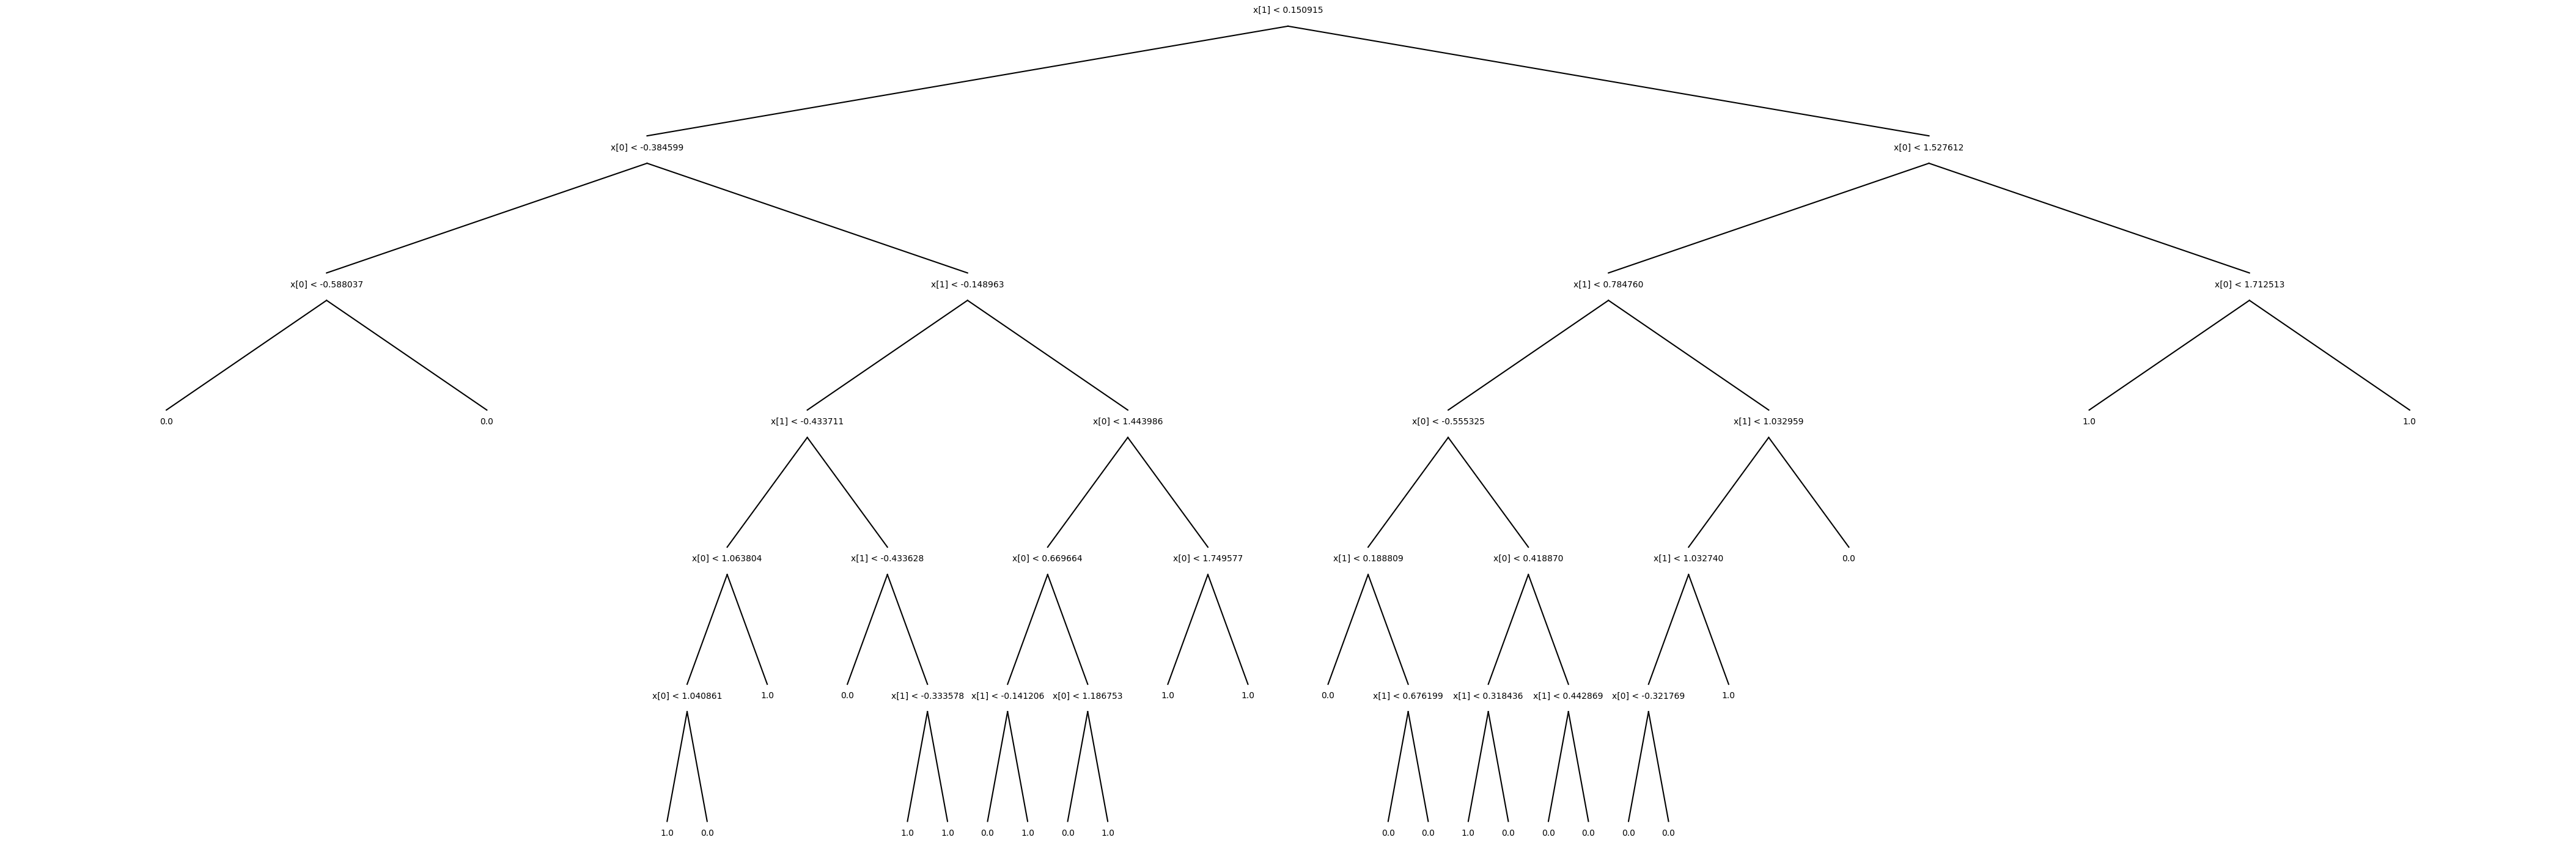

In [7]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

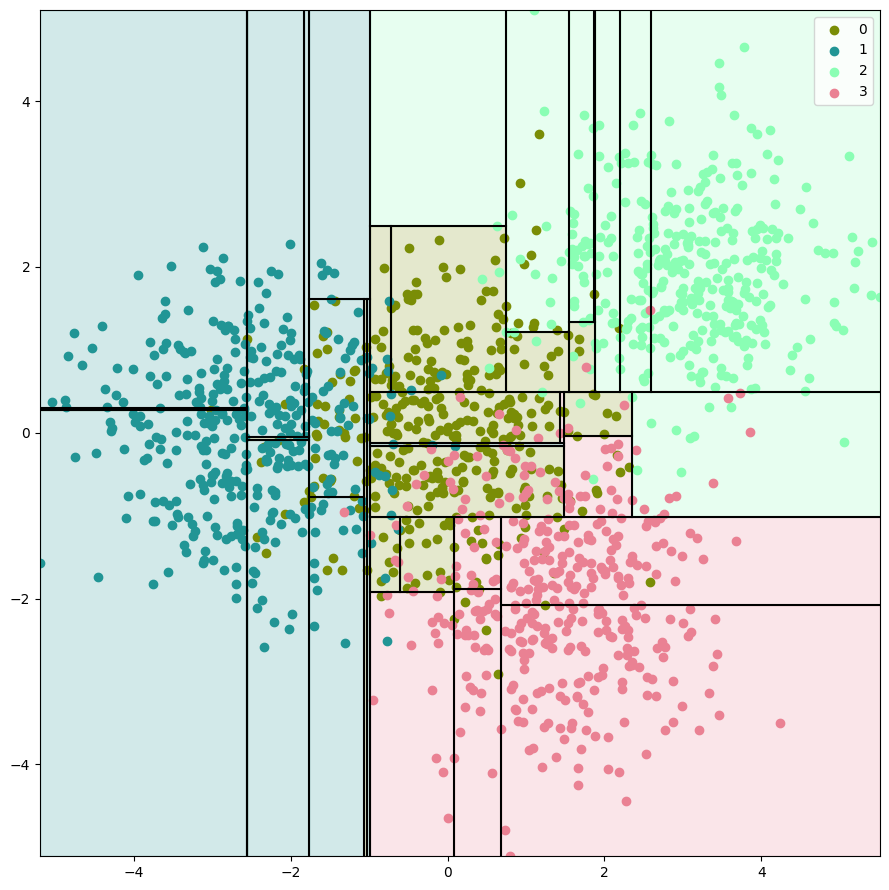

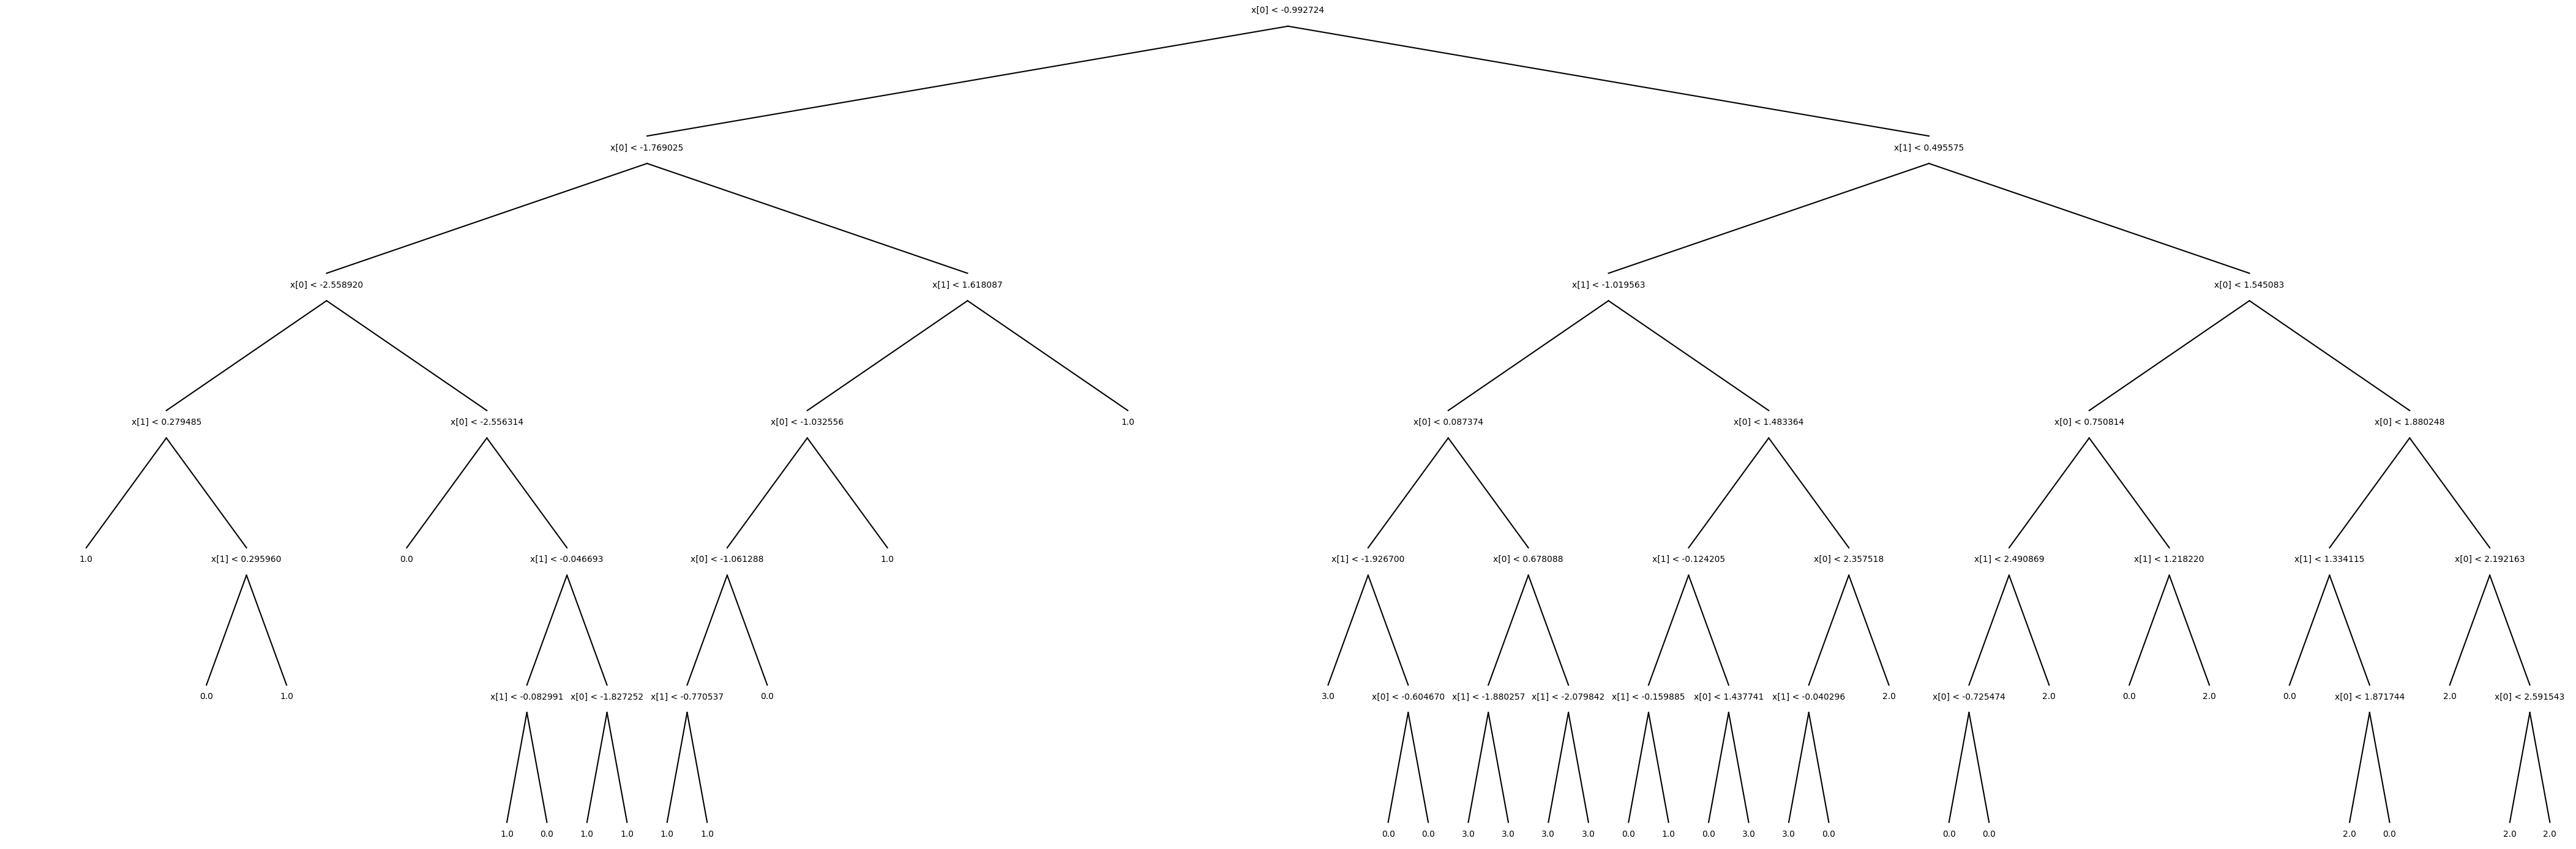

In [8]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (4 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 2 балла - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 4 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [9]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [10]:
from task import task4_dtc
X, y = read_dataset("train.csv")
task4_dtc.fit(X, y)